<font size="+3">Deep-Convolutional Generative Adversarial Network (DCGAN)</font>

# Imports & Settings

In [61]:
# Allows imports from modules in the project directory
import os
import sys
from pathlib import Path
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

PROJECT_DIRECTORY = Path(os.path.abspath('')).resolve().parents[1]
sys.path.extend([str(PROJECT_DIRECTORY)])

DATA_DIRECTORY = Path(os.path.abspath('')).resolve().parents[3]
sys.path.extend([str(DATA_DIRECTORY)])

print(f'Python {sys.version} on {sys.platform}')

Python 3.9.19 (main, Jul  7 2024, 08:52:44) 
[Clang 15.0.0 (clang-1500.3.9.4)] on darwin


In [62]:
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from IPython import display
import tensorflow as tf
from tqdm import tqdm
import numpy as np
import time
import pandas as pd

import utilities

In [63]:
tf.__version__

'2.12.0'

# 0. Data Preparation

For simplicity: only choose one specific feature of the data

In [64]:
NORMALIZATION = True
COMPRESS = True
COMPRESSION_SIZE = 128

In [65]:
# Load and split dataset
data, labels, fids, velocities, angles = utilities.load_dataset(PROJECT_DIRECTORY / 'data/data_adp.pkl')
train_idx, test_idx, train_data, test_data = utilities.split_dataset(fids, labels, data, seed = 100)

# Clear
del data

# Pre-processind
if NORMALIZATION:
    utilities.normalize_data(train_data)

if COMPRESS:
    utilities.compress_data(train_data, COMPRESSION_SIZE)
    train_data = np.array(train_data)

train_labels = labels[train_idx]
print(train_data.shape)

(26975, 128, 6)


In [7]:
# Extract only first feature of time-series data
train_data_0 = train_data[train_labels==0]

(3027, 128, 1)


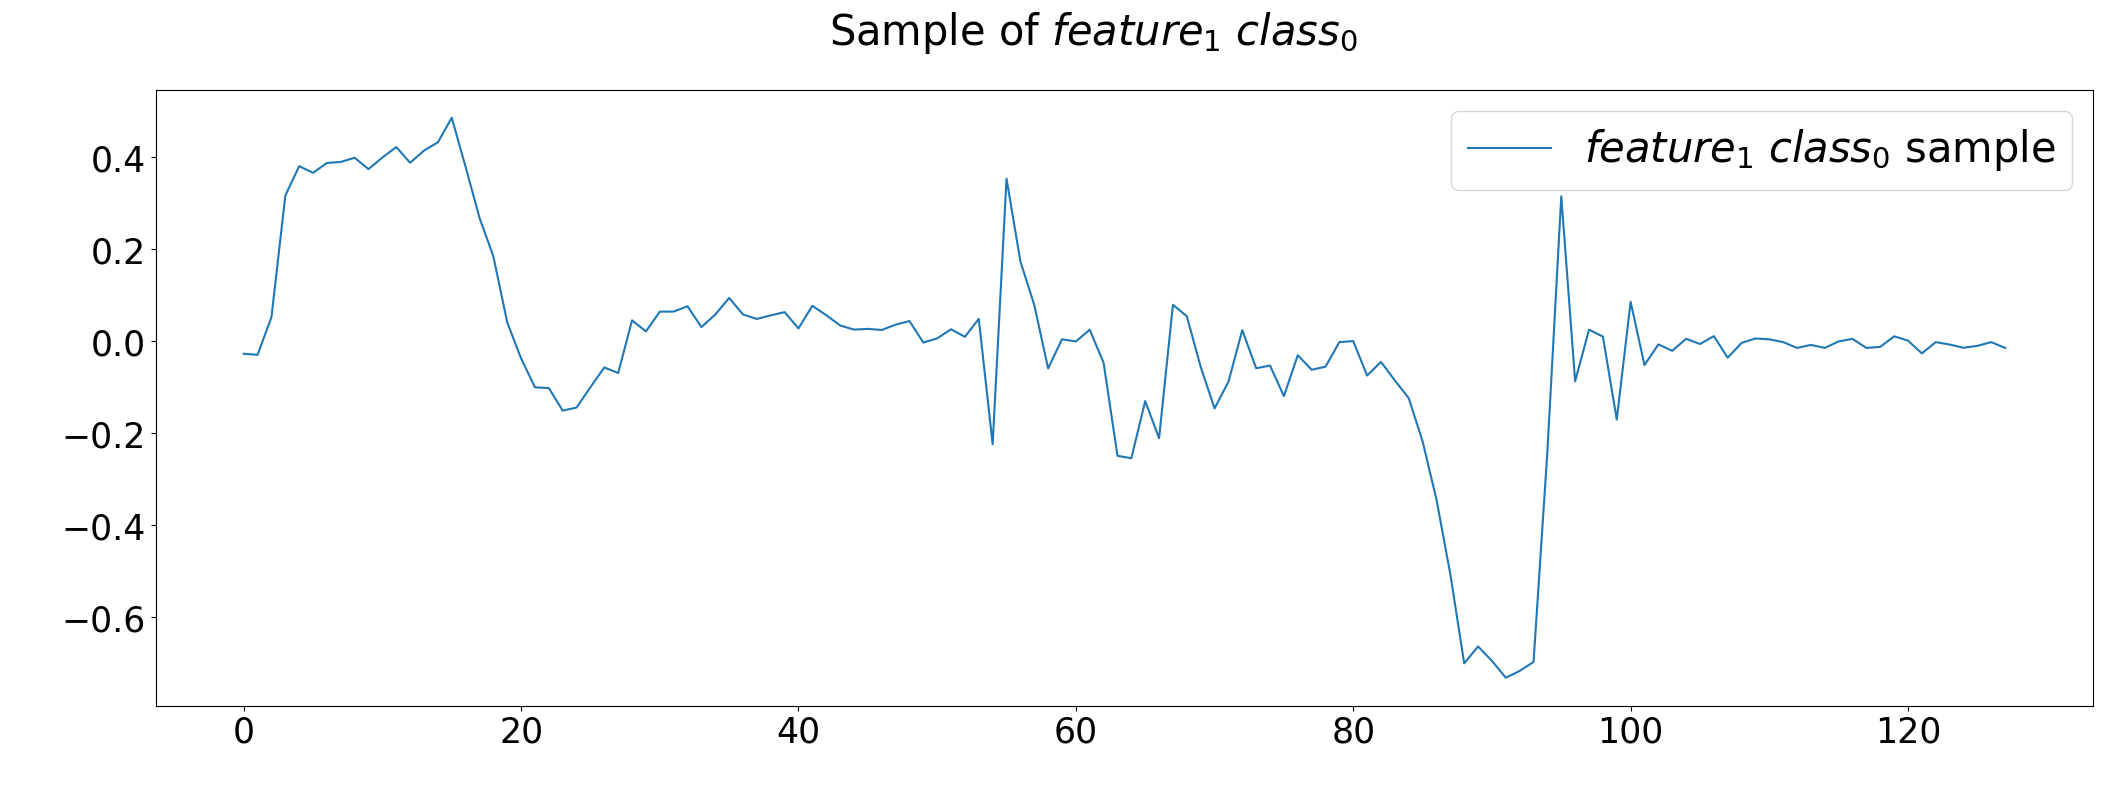

In [68]:
train_feature_data = train_data_0[:,:,[0]]

print(train_feature_data.shape)

fig, axs = plt.subplots(1, 1, figsize=(25, 8))
sample_points = np.arange(train_feature_data.shape[1])

axs.plot(sample_points, train_feature_data[0][:], label=r'$feature_1$ $class_0$ sample')
axs.legend()

axs.set_ylabel(r"$amplitude_1$", fontsize=30, color='w')
axs.set_xlabel(f"Sample Length {len(sample_points)})", fontsize=25, color='w')
fig.suptitle(r"Sample of $feature_1$ $class_0$", fontsize=30)

plt.xticks(fontsize = 25)
plt.yticks(fontsize = 25)
axs.legend(fontsize="30")

In [69]:
# Generate Mini Batches for Training
train_feature_dataset = tf.data.Dataset.from_tensor_slices(train_feature_data)

BATCH_SIZE = 64
SHUFFLE_BUFFER_SIZE = len(train_feature_dataset)

# drop_remainder=True, generate equally sized batches
train_feature_dataset_batch = train_feature_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)

In [70]:
for d in train_feature_dataset.take(1):
  print('data ', d.shape)
  print('data.shape: ', d.shape[0])

for d in train_feature_dataset_batch.take(1):
  print('data.shape: ', d.shape)

data  (128, 1)
data.shape:  128
data.shape:  (64, 128, 1)


# 1. Define DCGAN Components

###  Network Parameter

Following the settings in tutorial on TensorFlow [Tutorial von TensorFlow](https://www.tensorflow.org/tutorials/generative/dcgan)

In [71]:
sequence_length = COMPRESSION_SIZE
n_seq = 1
batch_size = 128
hidden_dim_first_gen = 256
hidden_dim_second_gen = 128
noise_dim = COMPRESSION_SIZE * 8

## 1.1 Generator

In [72]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(int(sequence_length/4*batch_size), use_bias=False, input_shape=(noise_dim,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((int(sequence_length/4), batch_size)))
    assert model.output_shape == (None, int(sequence_length/4), batch_size), model.output_shape 

    model.add(layers.Conv1DTranspose(hidden_dim_first_gen, 5, strides=1, padding='same', use_bias=False))
    assert model.output_shape == (None, int(sequence_length/4), hidden_dim_first_gen), model.output_shape
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv1DTranspose(hidden_dim_second_gen, 5, strides=2, padding='same', use_bias=False))
    assert model.output_shape == (None, int(sequence_length/2), hidden_dim_second_gen), model.output_shape
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv1DTranspose(n_seq, 5, strides=2, padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, sequence_length, n_seq), model.output_shape # Output size

    return model

### Generate Synthetic Data (untrained)

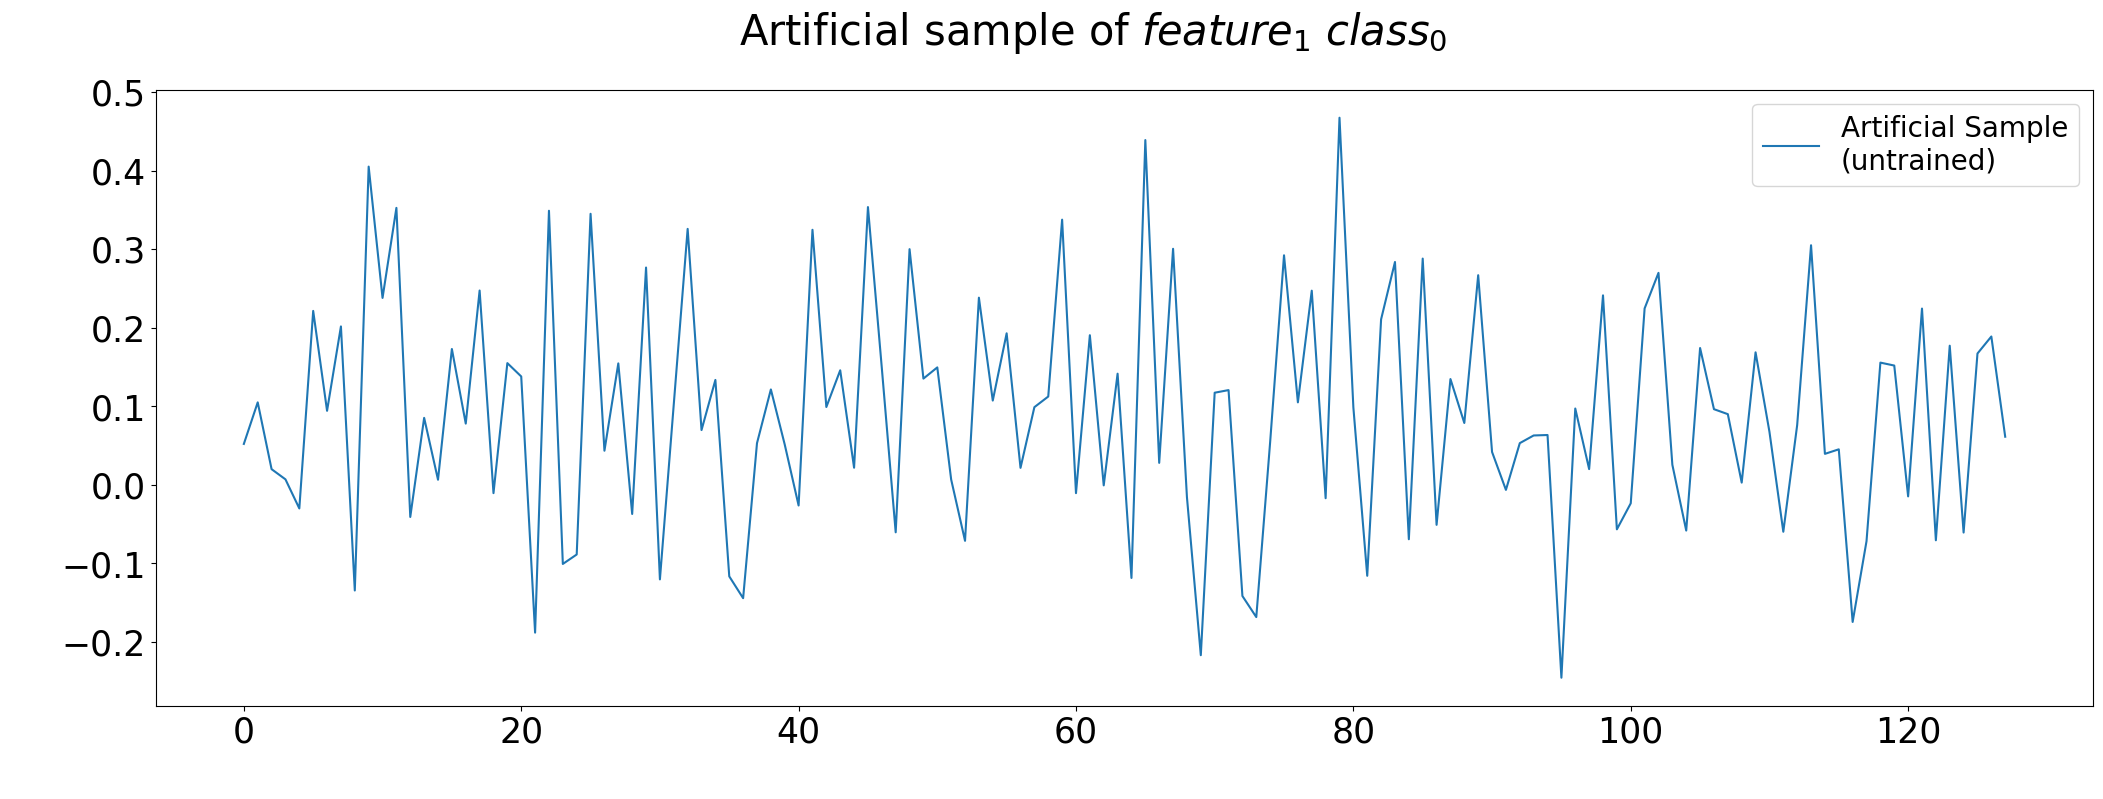

In [75]:
generator = make_generator_model()

noise = tf.random.normal([1,noise_dim])
#noise = tf.random.uniform([1,noise_dim],-1,1) # alternative distribution
generated_sample = generator(noise, training=False)

fig, axs = plt.subplots(1, 1, figsize=(25, 8))
sample_points = np.arange(generated_sample.shape[1])

axs.plot(sample_points, generated_sample[0][:], label=r'Artificial Sample' + '\n' + '(untrained)')

fig.suptitle(r"Artificial sample of $feature_1$ $class_0$", fontsize=30)
axs.set_ylabel(r"$amplitude_1$", fontsize=30, color='w')
axs.set_xlabel(f"Sample Length {len(sample_points)})", fontsize=25, color='w')

plt.xticks(fontsize = 25)
plt.yticks(fontsize = 25)
axs.legend(fontsize="20", loc='upper right')

In [76]:
generator.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 4096)              4194304   
                                                                 
 batch_normalization_9 (Batc  (None, 4096)             16384     
 hNormalization)                                                 
                                                                 
 leaky_re_lu_11 (LeakyReLU)  (None, 4096)              0         
                                                                 
 reshape_3 (Reshape)         (None, 32, 128)           0         
                                                                 
 conv1d_transpose_9 (Conv1DT  (None, 32, 256)          163840    
 ranspose)                                                       
                                                                 
 batch_normalization_10 (Bat  (None, 32, 256)         

## 1.2 Discriminator


In [77]:
hidden_dim_first_disc = hidden_dim_second_gen
hidden_dim_second_disc = hidden_dim_first_gen
hidden_dim_third_disc = hidden_dim_first_gen

In [78]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv1D(batch_size, 5, strides=2, padding='same', input_shape=[sequence_length, n_seq]))
    assert model.output_shape == (None, sequence_length/2, batch_size), model.output_shape
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv1D(hidden_dim_first_disc, 5, strides=2, padding='same'))
    assert model.output_shape == (None, sequence_length/4, hidden_dim_first_disc), model.output_shape

    model.add(layers.Conv1D(hidden_dim_third_disc, 5, strides=2, padding='same'))
    assert model.output_shape == (None, sequence_length/8, hidden_dim_second_disc), model.output_shape

    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [79]:
# discriminate (untrained)
discriminator = make_discriminator_model()
decision = discriminator(generated_sample)

print(decision)

tf.Tensor([[0.02669393]], shape=(1, 1), dtype=float32)


In [80]:
discriminator.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_3 (Conv1D)           (None, 64, 128)           768       
                                                                 
 leaky_re_lu_14 (LeakyReLU)  (None, 64, 128)           0         
                                                                 
 dropout_2 (Dropout)         (None, 64, 128)           0         
                                                                 
 conv1d_4 (Conv1D)           (None, 32, 128)           82048     
                                                                 
 conv1d_5 (Conv1D)           (None, 16, 256)           164096    
                                                                 
 leaky_re_lu_15 (LeakyReLU)  (None, 16, 256)           0         
                                                                 
 dropout_3 (Dropout)         (None, 16, 256)          

## 2.0 Joint Training

In [81]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

## 2.1 Discriminator Loss


In [82]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

## 2.2 Generator loss


In [83]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [84]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

## 2.3 Training Loop

In [85]:
EPOCHS = 10
num_examples_to_generate = 124

seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [86]:
@tf.function
def train_step_discriminator(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return  disc_loss

In [87]:
@tf.function
def train_step_generator():
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape:
      generated_images = generator(noise, training=True)

      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))

    return gen_loss

In [88]:
def generate_and_save_samples(model, epoch, test_input):

  predictions = model(test_input, training=False)

  fig, axs = plt.subplots(1, 1, figsize=(12, 4))
  sample_points = np.arange(predictions.shape[1])
  
  fig.suptitle(f"Artificial sample of $feature_1$ of $class_0$ after {epoch} epochs", fontsize=30)
  axs.plot(sample_points, predictions[0][:], label=r'Artificial Sample' + '\n' + '(during training)')
  
  axs.set_ylabel(r"$amplitude_1$", fontsize=30, color='w')
  axs.set_xlabel(f"Sample Length {len(sample_points)})", fontsize=25, color='w')

  plt.xticks(fontsize = 12)
  plt.yticks(fontsize = 12)
  axs.legend(fontsize="15", loc='upper right')
  plt.show()

In [89]:
def train(dataset, epochs):
  history = []
  for epoch in range(epochs):
    start = time.time()

    gen_loss = []
    disc_loss = []

    pbar = tqdm(dataset)
    for sample_batch in pbar:
      # Trainiere Generator 2x as much
      for kk in range(1):
        loss_gen = train_step_generator()
        gen_loss.append(loss_gen)

      # Furthermore possible to control the training
      #if np.mean(gen_loss) < 1:
      loss_disc = train_step_discriminator(sample_batch)
      disc_loss.append(loss_disc)

      pbar.set_description("gen_loss {:5.5f}; disc_loss {:5.5f}".format(np.mean(gen_loss),np.mean(disc_loss)))

    history.append((np.mean(gen_loss),np.mean(disc_loss)))

    display.clear_output(wait=True)
    generate_and_save_samples(generator, epoch + 1,seed)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))
    print('Loss for Generator: {}'.format(history[-1][0]))
    print('Loss for Discriminator: {}'.format(history[-1][1]))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_samples(generator, epochs,seed)

  return history


## Train the model
Call the `train()` method defined above to train the generator and discriminator simultaneously. Note, training GANs can be tricky. It's important that the generator and discriminator do not overpower each other (e.g., that they train at a similar rate).

At the beginning of the training, the generated images look like random noise. As training progresses, the generated digits will look increasingly real. After about 50 epochs, they resemble MNIST digits. This may take about one minute / epoch with the default settings on Colab.

In [28]:
history = train(train_feature_dataset_batch, EPOCHS)

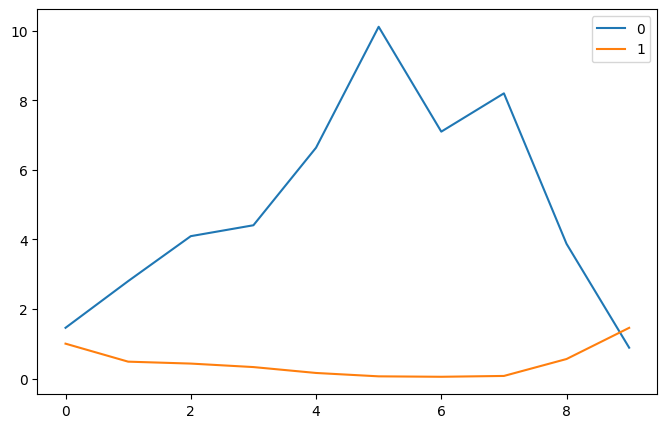

In [31]:
# plot the training history
pd.DataFrame(history).plot(figsize=(8, 5))
plt.show()

### Generate Synthetic Data


In [32]:
SAMPLES = train_feature_data.shape[0] 

noise = tf.random.normal([SAMPLES,noise_dim])
generated_sample = generator(noise, training=False)

print(generated_sample.shape)

(3027, 128, 1)


In [90]:
generated_sample = np.load(PROJECT_DIRECTORY / 'GenerativeModel/GAN/models/dcgan/generated_data.npy')

### Create different plots

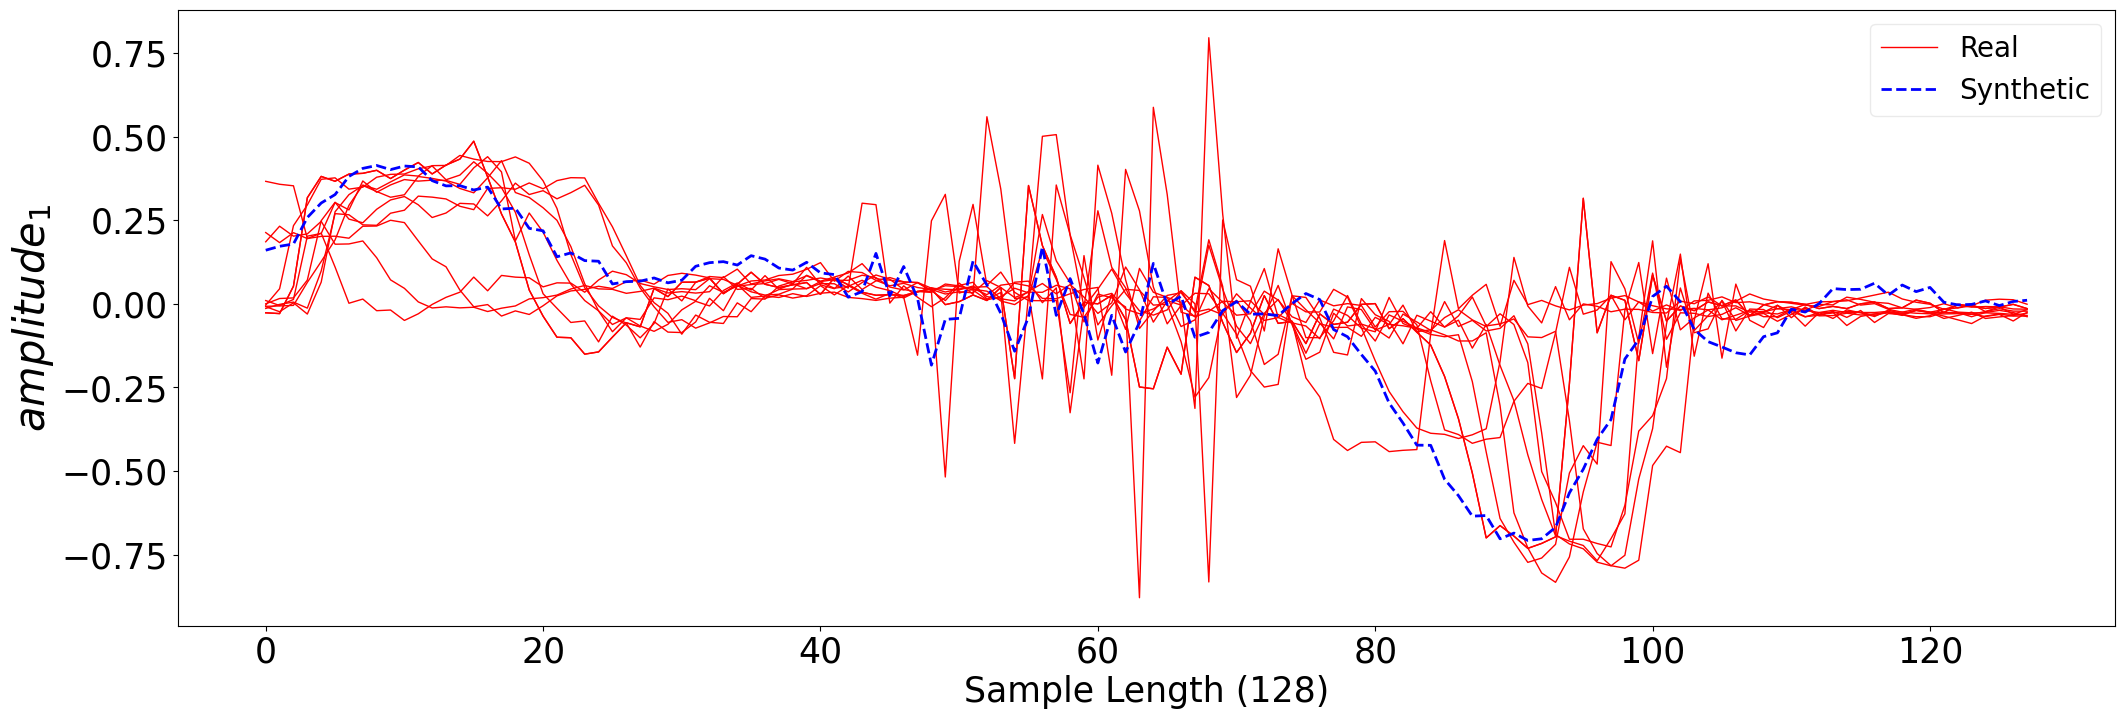

In [92]:
fig, axs = plt.subplots(1, 1, figsize=(25, 8))
sample_points = np.arange(generated_sample.shape[1])

axs.plot(sample_points, train_feature_data[0][:], 'r-', label='Real', lw=1)

for i in range(10):
    axs.plot(sample_points, train_feature_data[i][:], 'r-', lw=1)
axs.plot(sample_points, generated_sample[16][:], 'b--', label='Synthetic', lw=2)

axs.set_ylabel(r"$amplitude_1$", fontsize=30)
axs.set_xlabel(f"Sample Length ({len(sample_points)})", fontsize=25, color='black')

plt.xticks(fontsize = 25)
plt.yticks(fontsize = 25)

axs.tick_params(axis='x')
axs.tick_params(axis='y')

axs.spines['left'].set_color('black')
axs.spines['top'].set_color('black') 
axs.spines['bottom'].set_color('black') 
axs.spines['right'].set_color('black')

axs.legend(fontsize="20", framealpha=0.4)

In [93]:
print(generated_sample.shape)
print(train_feature_data.shape)

mean_generated_sample = np.array([np.mean(i) for i in np.transpose(generated_sample, (1,2,0))])
mean_train_feature_data = np.array([np.mean(i) for i in np.transpose(train_feature_data, (1,2,0))])


print(mean_generated_sample.shape)
print(mean_train_feature_data.shape)

(100, 128, 1)
(3027, 128, 1)
(128,)
(128,)


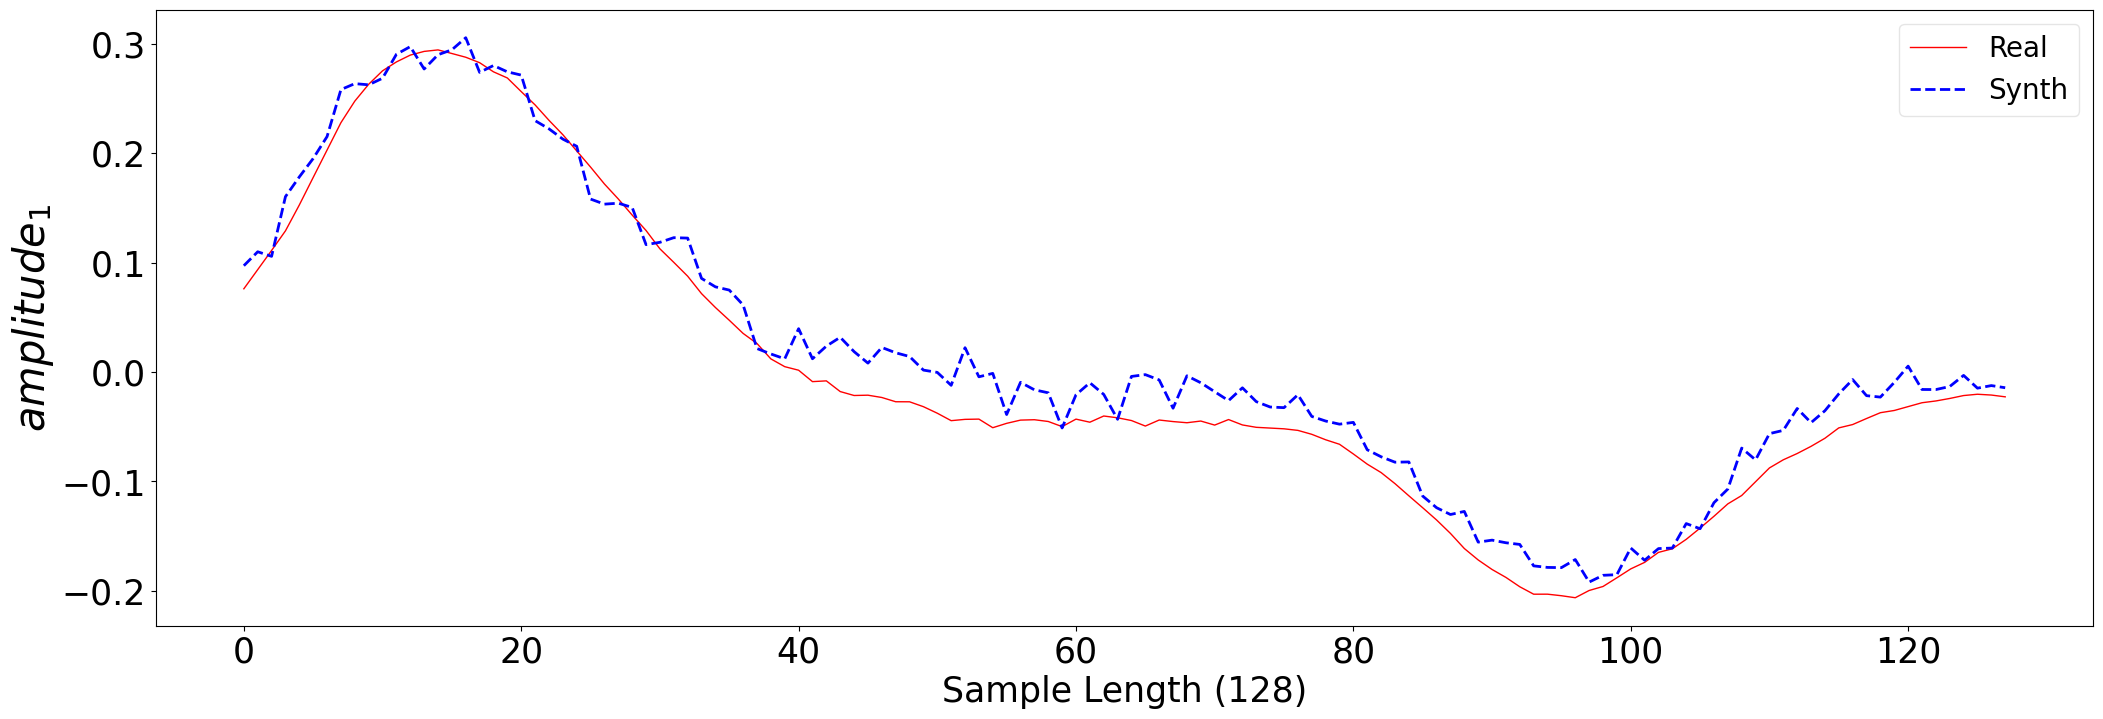

In [94]:
fig, axs = plt.subplots(1, 1, figsize=(25, 8))
sample_points = np.arange(generated_sample.shape[1])

axs.plot(sample_points, mean_train_feature_data, 'r-', label='Real', lw=1)
axs.plot(sample_points, mean_generated_sample,'b--', label='Synth', lw=2)

axs.set_ylabel(r"$amplitude_1$", fontsize=30)
axs.set_xlabel(f"Sample Length ({len(sample_points)})", fontsize=25)

plt.xticks(fontsize = 25)
plt.yticks(fontsize = 25)

axs.tick_params(axis='x')
axs.tick_params(axis='y')

axs.spines['left'].set_color('black')
axs.spines['top'].set_color('black') 
axs.spines['bottom'].set_color('black') 
axs.spines['right'].set_color('black')

axs.legend(fontsize="20", framealpha=0.5)

Text(0.5, 0.98, 'Synthetic and real Sample of $feature_1$ of label $class_0$')

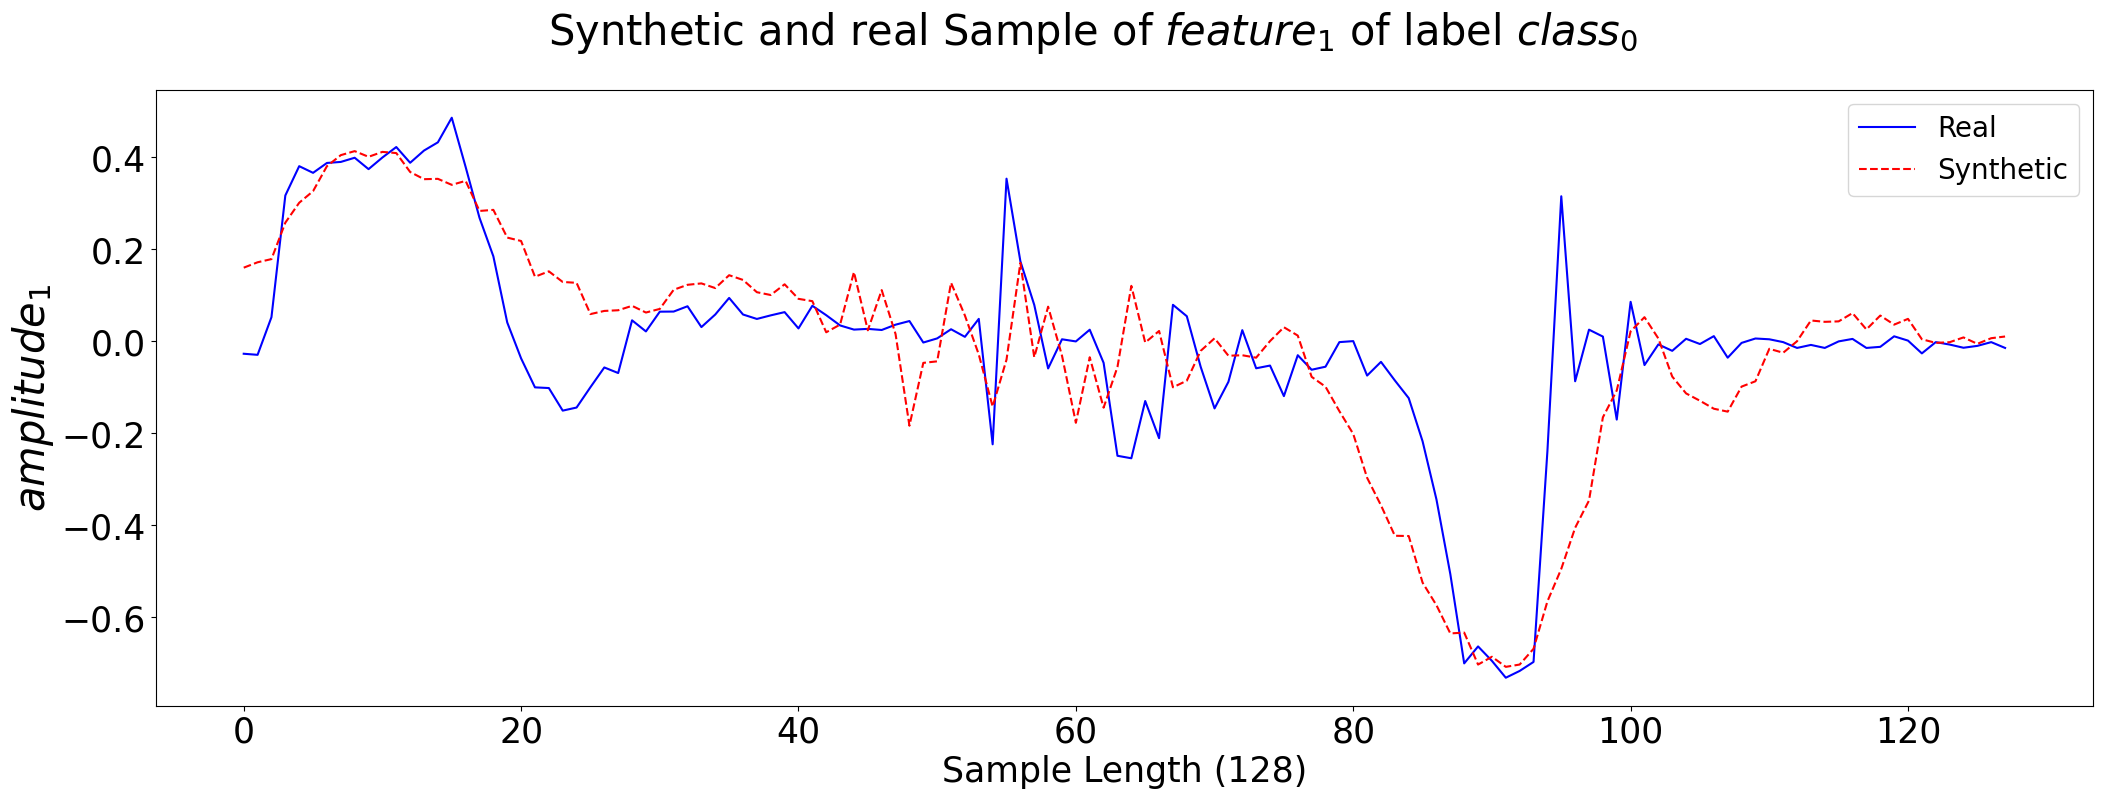

In [95]:
fig, axs = plt.subplots(1, 1, figsize=(25, 8))
sample_points = np.arange(generated_sample.shape[1])

axs.plot(sample_points, train_feature_data[0][:], 'b-', label='Real')

axs.plot(sample_points, generated_sample[16][:], 'r--', label='Synthetic')

axs.set_ylabel(r"$amplitude_1$", fontsize=30)
axs.set_xlabel(f"Sample Length ({len(sample_points)})", fontsize=25)

plt.xticks(fontsize = 25)
plt.yticks(fontsize = 25)
axs.legend(fontsize = "20")

fig.suptitle("Synthetic and real Sample of $feature_1$ of label $class_0$", fontsize=30)

In [96]:
print(generated_sample.shape)
print(train_feature_data.shape)

mean_generated_sample = np.array([np.mean(i) for i in np.transpose(generated_sample, (1,2,0))])
mean_train_feature_data = np.array([np.mean(i) for i in np.transpose(train_feature_data, (1,2,0))])


print(mean_generated_sample.shape)
print(mean_train_feature_data.shape)

(100, 128, 1)
(3027, 128, 1)
(128,)
(128,)


Text(0.5, 0.98, 'Synthetic and real mean of recording $feature_1$ of Label $class_0$')

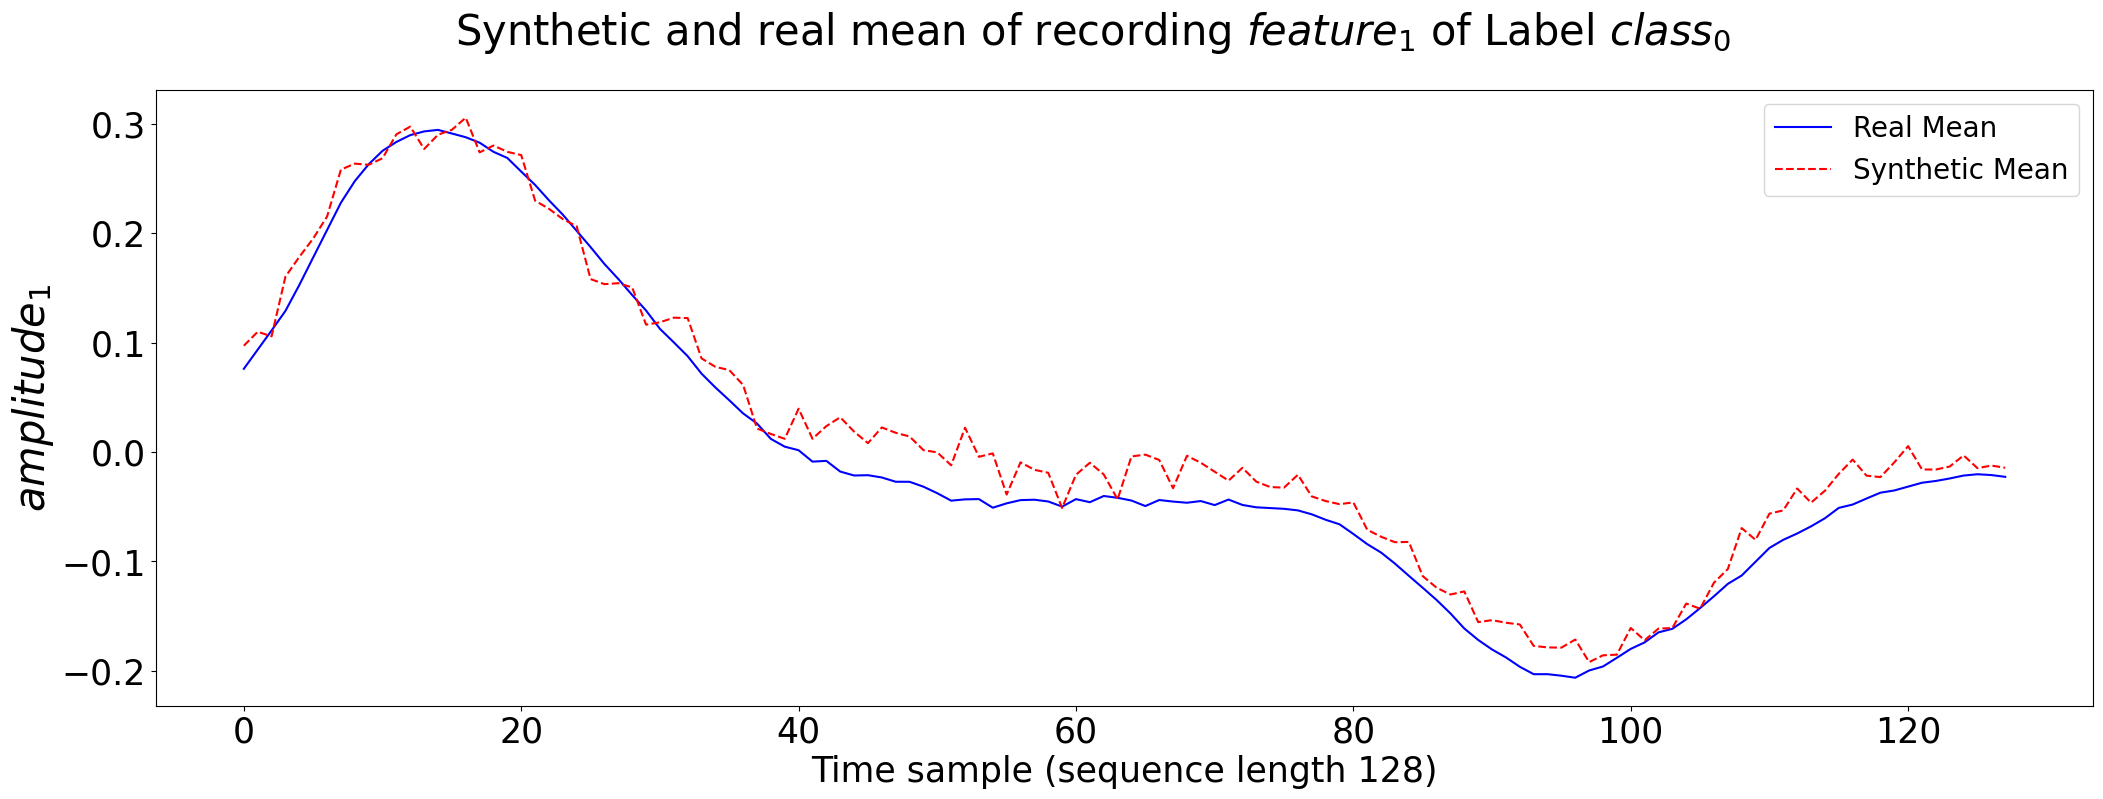

In [98]:
fig, axs = plt.subplots(1, 1, figsize=(25, 8))
sample_points = np.arange(generated_sample.shape[1])

axs.plot(sample_points, mean_train_feature_data, 'b-', label='Real Mean')
axs.plot(sample_points, mean_generated_sample, 'r--', label='Synthetic Mean')


axs.set_ylabel(r"$amplitude_1$", fontsize=30)
axs.set_xlabel(f"Time sample (sequence length {len(sample_points)})", fontsize=25)

plt.xticks(fontsize = 25)
plt.yticks(fontsize = 25)
axs.legend(fontsize="20")

fig.suptitle("Synthetic and real mean of recording $feature_1$ of label $class_0$", fontsize=30)

In [ ]:
# Safe generator and discriminator
generator.save(PROJECT_DIRECTORY / 'GenerativeModel/GAN/models/dcgan/generator128.h5', save_format='h5')
discriminator.save(PROJECT_DIRECTORY / 'GenerativeModel/GAN/models/dcgan/3discriminiator128.h5', save_format='h5')